#Project: RAG System based on Influenza research and evaluation

## Requirement:
     - The RAG system is supposed to utilize LLM to process research queries into highly formatted answers in addition to sources.
     - Implement Automated RAG System Evaluation of the architecture to evaluate hallucination, contextual precision and accuracy

# Build a Contextual Retrieval based RAG System

## Install OpenAI, and LangChain dependencies

In [ ]:
!pip install langchain==0.3.4
!pip install langchain-openai==0.2.3
!pip install langchain-community==0.3.3
!pip install jq==1.8.0
!pip install pymupdf==1.24.12
!!pip install dill

['Requirement already satisfied: dill in /usr/local/lib/python3.11/dist-packages (0.3.8)']

## Install Chroma Vector DB and LangChain wrapper

In [ ]:
!pip install langchain-chroma==0.1.4

In [ ]:
!pip install openai==1.55.3 httpx==0.27.2 --force-reinstall --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-server 1.24.0 requires anyio<4,>=3.1.0, but you have anyio 4.8.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-runtime-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-runtime-cu12 12.5.82

#Install Evaluation Libraries

In [ ]:
!pip install ragas==0.2.8
!pip install deepeval==1.4.7

## Enter Open AI API Key

In [ ]:
from getpass import getpass

OPENAI_KEY = getpass('Enter Open AI API Key: ')


Enter Open AI API Key: ··········


## Setup Environment Variables

In [ ]:
import os

os.environ['OPENAI_API_KEY'] = OPENAI_KEY

### Open AI Embedding Models

LangChain enables us to access Open AI embedding models which include the newest models: a smaller and highly efficient `text-embedding-3-small` model, and a larger and more powerful `text-embedding-3-large` model.

In this project, we will use small embedding model for cost efficiency sake.

In [ ]:
from langchain_openai import OpenAIEmbeddings

# details here: https://openai.com/blog/new-embedding-models-and-api-updates
openai_embed_model = OpenAIEmbeddings(model='text-embedding-3-small')

## Loading and Processing the Data

We can load all kinds of dataset including the following:
 - Tabular dataset from SQL database
 - Unstructured datasets from No SQL databases (MongoDB, Cassandra etc)
 - Wiki and Json files
 - Office documents - Word, Powerpoint
 - PDF files.

In this project we restrict the documents to PDFs only.
We can use **unstructured.io** (An open source document processing to load all kinds of data formats)

### Get the dataset

In [ ]:
from glob import glob

pdf_files = glob('./infection_studies/*.pdf')
pdf_files

['./infection_studies/Augusta_From_RNA.pdf',
 './infection_studies/Integrative_computational_approach.pdf',
 './infection_studies/COMO_pipeline_for_multiomics.pdf',
 './infection_studies/APznzaagF0zZ2z2pR7oUXW4Sf04oUm1WfwVcLsgGS1T3yU67osvX43lTsY1ZrEgqqBqXXj_TAgjx0rjpHSa2C9vOwT8zbvmMEnm3d2M3JJx1-GfNUSzSbrd-HT0JjiO_8A_Nfjoa4OgGx1QvEtUyZcVt6rcDYevBokCm18Hsbk1wZr1x2-pKS43-sK5Q_Q7lOkESFLZjn8rTXWmlaBZz9ipS99rfR77hSxU4amUwF7oK2H1j.pdf',
 './infection_studies/A_multiscale_mechanistic_model_dendritic_model.pdf',
 './infection_studies/A_multiapproach_multiscale_platform_to_model_CD4.pdf',
 './infection_studies/CSB_lecture_flux_balance_analysis.pdf',
 './infection_studies/A_mechanistic_computation_approach.pdf']

### Create Chunk Contexts for Contextual Retrieval

 - Prepare chunk specific explanatory context to each chunk before creating the vector DB embeddings and TF-DF vectors
 - This helps in having keywords phrases in eah chunk based on its relevant to the overall document


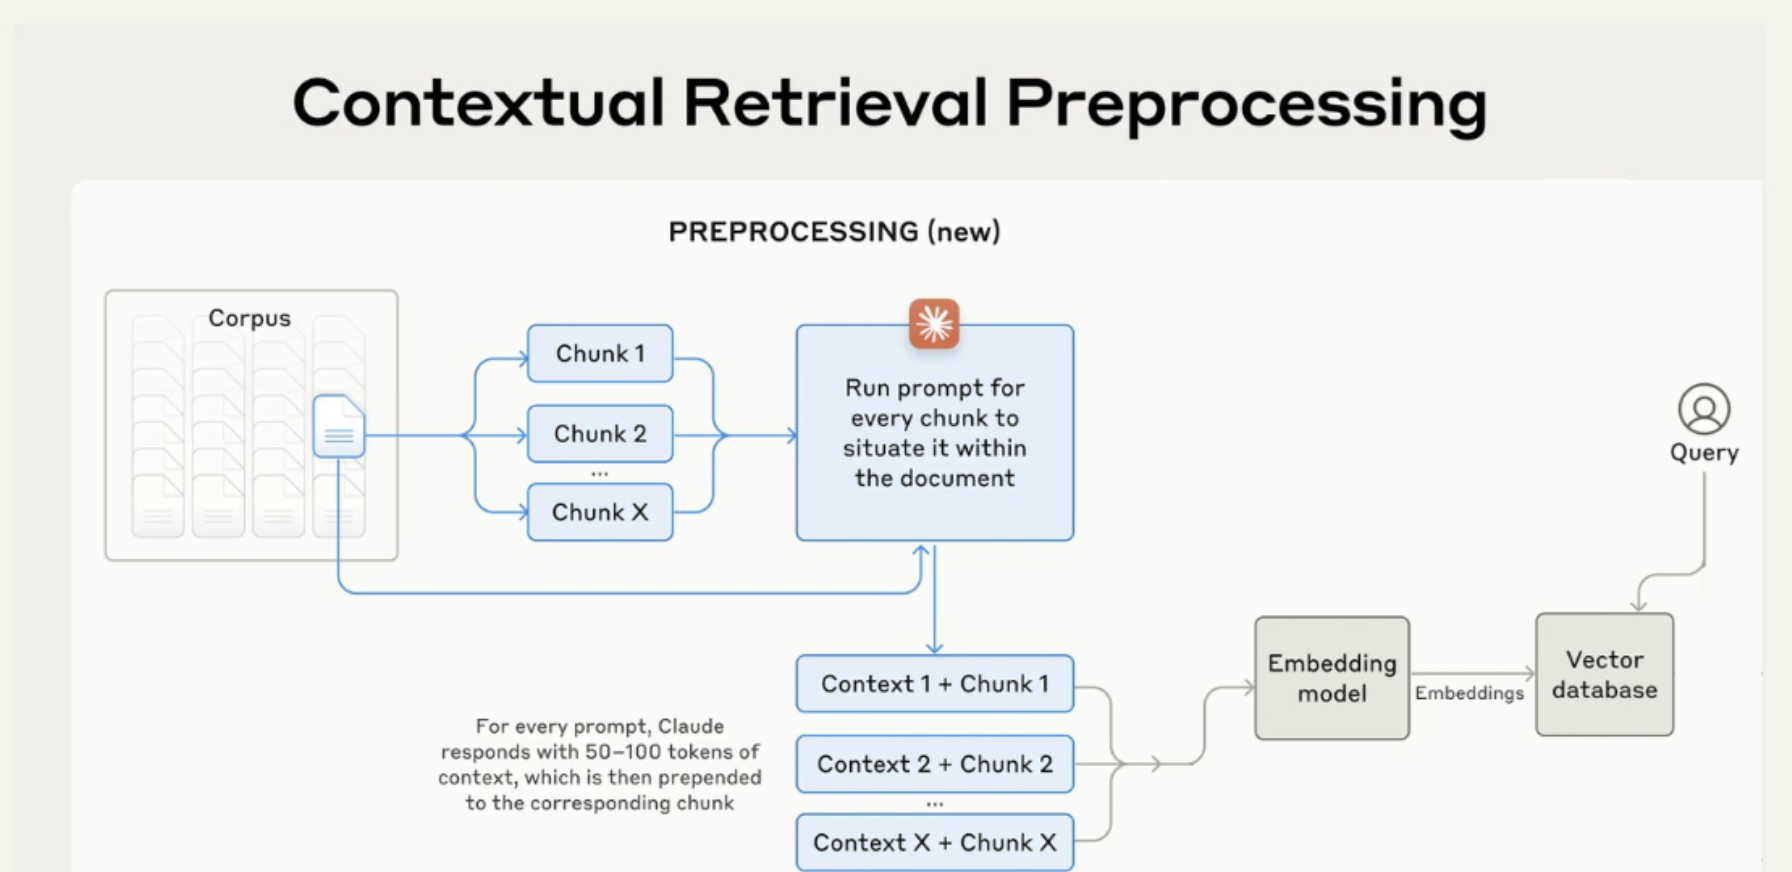

In [ ]:
from langchain_openai import ChatOpenAI

chatgpt = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

In [ ]:
# create chunk context generation chain
from langchain.prompts import ChatPromptTemplate
from langchain.schema import StrOutputParser


def generate_chunk_context(document, chunk):

    chunk_process_prompt = """You are an AI assistant specializing in research paper analysis.
                            Your task is to provide brief, relevant context for a chunk of text
                            based on the following research paper.

                            Here is the research paper:
                            <paper>
                            {paper}
                            </paper>

                            Here is the chunk we want to situate within the whole document:
                            <chunk>
                            {chunk}
                            </chunk>

                            Provide a concise context (3-4 sentences max) for this chunk,
                            considering the following guidelines:

                            - Give a short succinct context to situate this chunk within the overall document
                            for the purposes of improving search retrieval of the chunk.
                            - Answer only with the succinct context and nothing else.
                            - Context should be mentioned like 'Focuses on ....'
                            do not mention 'this chunk or section focuses on...'

                            Context:
                        """

    prompt_template = ChatPromptTemplate.from_template(chunk_process_prompt)

    agentic_chunk_chain = (prompt_template
                                |
                            chatgpt
                                |
                            StrOutputParser())

    context = agentic_chunk_chain.invoke({'paper': document, 'chunk': chunk})

    return context

In [ ]:
from langchain.docstore.document import Document

In [ ]:
from langchain.document_loaders import PyMuPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
import uuid

def create_contextual_chunks(file_path, chunk_size=3500, chunk_overlap=0):

    print('Loading pages:', file_path)
    loader = PyMuPDFLoader(file_path)
    doc_pages = loader.load()

    print('Chunking pages:', file_path)
    splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size,
                                              chunk_overlap=chunk_overlap)
    doc_chunks = splitter.split_documents(doc_pages)

    print('Generating contextual chunks:', file_path)
    original_doc = '\n'.join([doc.page_content for doc in doc_chunks])
    contextual_chunks = []
    for chunk in doc_chunks:
        chunk_content = chunk.page_content
        chunk_metadata = chunk.metadata
        chunk_metadata_upd = {
            'id': str(uuid.uuid4()),
            'page': chunk_metadata['page'],
            'source': chunk_metadata['source'],
            'title': chunk_metadata['source'].split('/')[-1]
        }
        context = generate_chunk_context(original_doc, chunk_content)
        contextual_chunks.append(Document(page_content=context+'\n'+chunk_content,
                                          metadata=chunk_metadata_upd))
    print('Finished processing:', file_path)
    print()
    return contextual_chunks

In [ ]:
paper_docs = []
for fp in pdf_files:
    paper_docs.extend(create_contextual_chunks(file_path=fp, chunk_size=1500))

Loading pages: ./infection_studies/Augusta_From_RNA.pdf
Chunking pages: ./infection_studies/Augusta_From_RNA.pdf
Generating contextual chunks: ./infection_studies/Augusta_From_RNA.pdf
Finished processing: ./infection_studies/Augusta_From_RNA.pdf

Loading pages: ./infection_studies/Integrative_computational_approach.pdf
Chunking pages: ./infection_studies/Integrative_computational_approach.pdf
Generating contextual chunks: ./infection_studies/Integrative_computational_approach.pdf
Finished processing: ./infection_studies/Integrative_computational_approach.pdf

Loading pages: ./infection_studies/COMO_pipeline_for_multiomics.pdf
Chunking pages: ./infection_studies/COMO_pipeline_for_multiomics.pdf
Generating contextual chunks: ./infection_studies/COMO_pipeline_for_multiomics.pdf
Finished processing: ./infection_studies/COMO_pipeline_for_multiomics.pdf

Loading pages: ./infection_studies/APznzaagF0zZ2z2pR7oUXW4Sf04oUm1WfwVcLsgGS1T3yU67osvX43lTsY1ZrEgqqBqXXj_TAgjx0rjpHSa2C9vOwT8zbvmMEnm3d2M3

In [ ]:
#len(paper_docs)
import pickle

filename = 'paper_docs.pkl'

# Open the file in binary write mode ('wb')
with open(filename, 'wb') as file:
    # Use pickle.dump() to serialize and save the object
    pickle.dump(paper_docs, file)

In [ ]:
paper_docs[0]

Document(metadata={'id': '61ef3741-7c2c-4a6b-9d8d-edcaeb28fa17', 'page': 0, 'source': './infection_studies/Augusta_From_RNA.pdf', 'title': 'Augusta_From_RNA.pdf'}, page_content='Focuses on the introduction and publication details of the research article titled "Augusta: From RNA-Seq to gene regulatory networks and Boolean models," which presents a new computational tool for inferring gene regulatory networks (GRNs) and Boolean models from RNA sequencing data. It highlights the significance of computational models in understanding gene regulation and addresses the limitations of existing models in analyzing whole genomes. The authors and their affiliations are also provided, along with keywords relevant to the study.\nComputational and Structural Biotechnology Journal 23 (2024) 783–790\nAvailable online 20 January 2024\n2001-0370/© 2024 The Authors. Published by Elsevier B.V. on behalf of Research Network of Computational and Structural Biotechnology. This is an open access\narticle und

## Index Document Chunks and Embeddings in Vector DB

Here we initialize a connection to a Chroma vector DB client, and also we want to save to disk, so we simply initialize the Chroma client and pass the directory where we want the data to be saved to.

In [ ]:
from langchain_chroma import Chroma

# create vector DB of docs and embeddings -
chroma_db = Chroma.from_documents(documents=paper_docs,
                                  collection_name='my_context_db',
                                  embedding=openai_embed_model,
                                  collection_metadata={"hnsw:space": "cosine"},
                                  persist_directory="./my_context_db")

### Load Vector DB from disk

This is just to show once you have a vector database on disk you can just load and create a connection to it anytime

In [ ]:
# load from disk
chroma_db = Chroma(persist_directory="./my_context_db",
                   collection_name='my_context_db',
                   embedding_function=openai_embed_model)

In [ ]:
chroma_db

### Semantic Similarity based Retrieval

We use simple cosine similarity here and retrieve the top 5 similar documents based on the user input query

In [ ]:
similarity_retriever = chroma_db.as_retriever(search_type="similarity",
                                              search_kwargs={"k": 5})

In [ ]:
from IPython.display import display, Markdown

def display_docs(docs):
    for doc in docs:
        print('Metadata:', doc.metadata)
        print('Content Brief:')
        display(Markdown(doc.page_content[:1000]))
        print()

In [ ]:
query = "Explain CD4+ T cell differentiation?"
top_docs = similarity_retriever.invoke(query)
display_docs(top_docs)

Metadata: {'id': '4d68588f-4841-4dd5-9c0f-ec7ba072bb41', 'page': 1, 'source': './infection_studies/A_mechanistic_computation_approach.pdf', 'title': 'A_mechanistic_computation_approach.pdf'}
Content Brief:


Focuses on the differentiation of CD4+ T cells into various phenotypes, including mixed (complex) phenotypes such as Th1–Th2 and Th1–Th17. It discusses the regulatory mechanisms involving multiple signaling pathways, particularly the JAK/STAT pathways, and the roles of specific transcription factors (TFs) like Tbet, GATA3, and RORγt in this process. Additionally, it highlights the inhibitory effects of TGF-β on certain T cell lineages and its role in promoting iTreg differentiation.
such mixed (complex) phenotypes include Th1–Th2 (Peine et al.,
2013; Bock et al., 2017) and Th1–Th17 (Kullberg et al., 2006;
Morrison et al., 2013).
The diﬀerentiation process is governed by the regulation of
multiple, mutually cross-linked signaling pathways, which form
complex networks (Zhu et al., 2010). The stimulation of the
naive CD4+ T cells by various cytokines triggers a cascade
of signaling events, such as the activation of the JAK/STAT
pathways that lead to the activation of T cell lineage-specif


Metadata: {'id': '908b34d1-2c1f-49a8-88f2-ae5515a7b7b0', 'page': 1, 'source': './infection_studies/A_mechanistic_computation_approach.pdf', 'title': 'A_mechanistic_computation_approach.pdf'}
Content Brief:


Focuses on the classification and functional diversity of CD4+ T cells, including T helper subtypes such as Th1, Th2, Th17, and iTregs, and discusses the implications of cytokine signaling in T cell differentiation and plasticity. It highlights the ability of T helper cells to switch phenotypes based on environmental signals and the complexity of their regulatory networks.
Puniya et al.
Cytokine Mediated Regulation of T cell Differentiation
INTRODUCTION
The diversity and number of immunity-related diseases require a
high level of heterogeneity in the immune system to maintain the
overall well-being of a human. Early studies of immune responses
led to a discovery that the CD4+ T cells (referred to as T cells),
which are critical players in immunity, can be classiﬁed into
two subtypes - T helper 1 (Th1) and T helper 2 (Th2) cells
(Mosmann et al., 1986). Each type of eﬀector T cell produces a
speciﬁc set of cytokines that deﬁne the function of the cell and
the way it further governs the i


Metadata: {'id': 'c088801b-f7c8-4977-9b60-43a4293d5c7b', 'page': 1, 'source': './infection_studies/A_mechanistic_computation_approach.pdf', 'title': 'A_mechanistic_computation_approach.pdf'}
Content Brief:


Focuses on the classification and functional diversity of CD4+ T cells, including T helper subtypes such as Th1, Th2, Th17, and iTregs, and discusses the implications of cytokine signaling in T cell differentiation and plasticity. It highlights the ability of T helper cells to switch phenotypes and the complexity of their regulatory networks.
Puniya et al.
Cytokine Mediated Regulation of T cell Differentiation
INTRODUCTION
The diversity and number of immunity-related diseases require a
high level of heterogeneity in the immune system to maintain the
overall well-being of a human. Early studies of immune responses
led to a discovery that the CD4+ T cells (referred to as T cells),
which are critical players in immunity, can be classiﬁed into
two subtypes - T helper 1 (Th1) and T helper 2 (Th2) cells
(Mosmann et al., 1986). Each type of eﬀector T cell produces a
speciﬁc set of cytokines that deﬁne the function of the cell and
the way it further governs the immune response. Speciﬁcally,
th


Metadata: {'id': 'b109d153-611b-4f44-bcaf-893373a986af', 'page': 2, 'source': './infection_studies/A_multiapproach_multiscale_platform_to_model_CD4.pdf', 'title': 'A_multiapproach_multiscale_platform_to_model_CD4.pdf'}
Content Brief:


Describes the lifecycle of CD4+ T cells, detailing their progression from naive Th0 cells through activation, expansion, and contraction stages, while emphasizing the dynamic behaviors influenced by intracellular signaling, gene regulation, and metabolic processes. Highlights the role of canonical pathways in the differentiation of various effector phenotypes and the integration of metabolic models to capture cell cycle-specific fluxes.
the antigen load and the activity of the rest of the immune system. A CD4+ T cell is created as
a naive cell with the Th0 phenotype and typically goes through three major stages: activation,
expansion, and contraction (including memory formation and cell death). The behaviors and
attributes of each cell are dynamic and depend on the outputs of the intracellular models of
signal transduction, gene regulation, and metabolism. The processes related to signal transduc-
tion and gene regulation include the canonical pathways regulating the transdifferentiati


Metadata: {'id': '9e77d8e3-a886-4bd9-b98e-314a673c0235', 'page': 16, 'source': './infection_studies/A_mechanistic_computation_approach.pdf', 'title': 'A_mechanistic_computation_approach.pdf'}
Content Brief:


Focuses on various studies that contribute to the understanding of CD4+ T cell differentiation and plasticity, highlighting the roles of specific cytokines and regulatory networks in shaping T cell responses. It references key research on Th17 cell plasticity, the characterization of T helper cell subsets, and the mechanisms driving T cell activation and differentiation.
Martinez-Sanchez, M. E., Mendoza, L., Villarreal, C., and Alvarez-Buylla, E. R.
(2015). A Minimal Regulatory Network of Extrinsic and Intrinsic Factors
Recovers Observed Patterns of CD4 + T Cell Diﬀerentiation and Plasticity.
PLoS Comput. Biol. 11:e1004324. doi: 10.1371/journal.pcbi.1004324
Morrison, P. J., Bending, D., Fouser, L. A., Wright, J. F., Stockinger, B., Cooke, A.,
et al. (2013). Th17-cell plasticity in Helicobacter hepaticus-induced intestinal
inﬂammation. Mucosal Immunol. 6, 1143–1156. doi: 10.1038/mi.2013.11
Mosmann, T. R., Cherwinski, H., Bond, M. W., Giedlin, M. A., and Coﬀman,
R. L. (1986). Two types o

# Stage 1: RAG System with Sources

  - LLM (GPT-4o) processes [user query + RAG proompt + context docs] to generate Answers + Sources


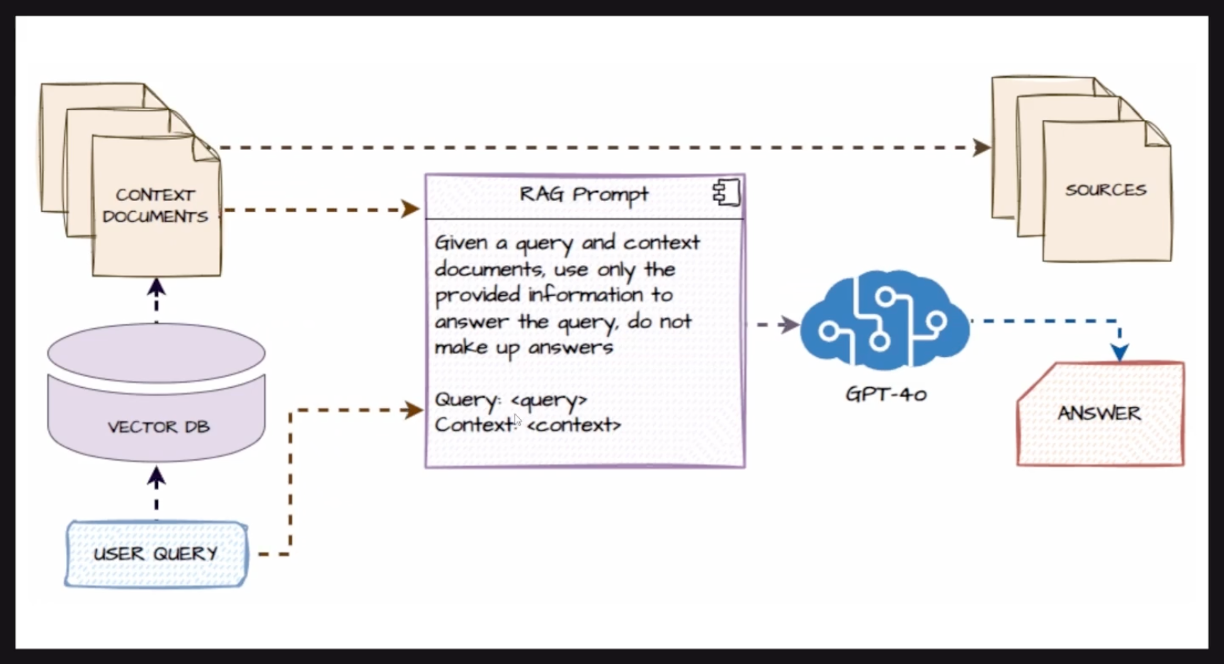

In [ ]:
from langchain_core.prompts import ChatPromptTemplate

rag_prompt = """You are an assistant who is an expert in question-answering tasks.
                Answer the following question using only the following pieces of retrieved context.
                If the answer is not in the context, do not make up answers, just say that you don't know.
                Keep the answer detailed and well formatted based on the information from the context.

                Question:
                {question}

                Context:
                {context}

                Answer:
            """

rag_prompt_template = ChatPromptTemplate.from_template(rag_prompt)

In [ ]:
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.runnables import RunnableLambda
from operator import itemgetter


chatgpt = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

src_rag_response_chain = (
    {
        "context": (itemgetter('context')
                        |
                    RunnableLambda(format_docs)),
        "question": itemgetter("question")
    }
        |
    rag_prompt_template
        |
    chatgpt
        |
    StrOutputParser()
)

rag_chain_w_sources = (
    {
        "context": similarity_retriever,
        "question": RunnablePassthrough()
    }
        |
    RunnablePassthrough.assign(response=src_rag_response_chain)
)

In [ ]:
#query = "How are CD4+ T cell differentiation regulated?"
#result = rag_chain_w_sources.invoke(query)
#result

In [ ]:
from IPython.display import display, Markdown

def display_results(result_obj):
    print('Query:')
    display(Markdown(result_obj['question']))
    print()
    print('Response:')
    display(Markdown(result_obj['response']))
    print('='*50)
    print('Sources:')
    for source in result_obj['context']:
        print('Metadata:', source.metadata)
        print('Content Brief:')
        display(Markdown(source.page_content))
        print()


In [ ]:
query = "How are CD4+ T cell differentiation regulated?"
result = rag_chain_w_sources.invoke(query)
display_results(result)

Query:


How are CD4+ T cell differentiation regulated?


Response:


CD4+ T cell differentiation is regulated through a complex interplay of signaling pathways and transcription factors. The process involves the following key mechanisms:

1. **Cytokine Signaling**: The differentiation of naive CD4+ T cells is initiated by various cytokines that trigger signaling cascades. These cytokines include interferon gamma (IFN-γ), interleukin-12 (IL-12), IL-4, IL-6, IL-21, IL-23, and transforming growth factor beta (TGF-β). Each cytokine influences the differentiation towards specific T helper (Th) cell lineages.

2. **JAK/STAT Pathways**: A critical component of the signaling process is the activation of the Janus kinase/signal transducer and activator of transcription (JAK/STAT) pathways. For instance:
   - **Th1 Differentiation**: This lineage is promoted by IFN-γ and IL-12, which activate STAT1 and STAT4, leading to the expression of the transcription factor Tbet.
   - **Th2 Differentiation**: IL-4 signaling activates STAT6, which in turn induces the expression of GATA3, a key transcription factor for Th2 cells.
   - **Th17 Differentiation**: The differentiation into Th17 cells is regulated by cytokines such as IL-6, IL-21, IL-23, and TGF-β, which activate the transcription factor RORγt.

3. **Transcription Factors**: Specific transcription factors play crucial roles in determining the lineage commitment of CD4+ T cells:
   - **Tbet**: Essential for Th1 differentiation.
   - **GATA3**: Critical for Th2 differentiation.
   - **RORγt**: Governs Th17 differentiation.
   - **Foxp3**: Important for the differentiation of inducible regulatory T cells (iTregs).

4. **Inhibitory Effects of TGF-β**: TGF-β has a dual role; it inhibits the differentiation of T cells into Th1 and Th2 lineages while promoting the commitment to the iTreg lineage. This highlights the regulatory complexity of TGF-β in T cell differentiation.

5. **Phenotypic Plasticity**: CD4+ T cells exhibit the ability to switch phenotypes based on environmental signals. For example, iTregs and Th17 cells can interchange their phenotypes in response to cytokines like IL-6. This plasticity is indicative of the dynamic nature of T cell responses.

6. **Complex Regulatory Networks**: The differentiation process is governed by multiple, mutually cross-linked signaling pathways that form intricate networks. This complexity allows for a diverse range of T cell responses tailored to specific immune challenges.

In summary, CD4+ T cell differentiation is a highly regulated process influenced by cytokine signaling, transcription factor activation, and the interplay of various signaling pathways, allowing for both stable lineage commitment and phenotypic plasticity.

Sources:
Metadata: {'id': '4d68588f-4841-4dd5-9c0f-ec7ba072bb41', 'page': 1, 'source': './infection_studies/A_mechanistic_computation_approach.pdf', 'title': 'A_mechanistic_computation_approach.pdf'}
Content Brief:


Focuses on the differentiation of CD4+ T cells into various phenotypes, including mixed (complex) phenotypes such as Th1–Th2 and Th1–Th17. It discusses the regulatory mechanisms involving multiple signaling pathways, particularly the JAK/STAT pathways, and the roles of specific transcription factors (TFs) like Tbet, GATA3, and RORγt in this process. Additionally, it highlights the inhibitory effects of TGF-β on certain T cell lineages and its role in promoting iTreg differentiation.
such mixed (complex) phenotypes include Th1–Th2 (Peine et al.,
2013; Bock et al., 2017) and Th1–Th17 (Kullberg et al., 2006;
Morrison et al., 2013).
The diﬀerentiation process is governed by the regulation of
multiple, mutually cross-linked signaling pathways, which form
complex networks (Zhu et al., 2010). The stimulation of the
naive CD4+ T cells by various cytokines triggers a cascade
of signaling events, such as the activation of the JAK/STAT
pathways that lead to the activation of T cell lineage-specifying
TFs (Murphy and Reiner, 2002; Kaiko et al., 2008). For example,
the commitment to Th1 lineage is initiated through signaling by
interferon gamma (IFN-γ) and IL-12, leading to the activation
of STAT1/STAT4, which in turn activate the T box expressed
in T cells (Tbet). Diﬀerentiation into Th2 is stimulated by the
activation of the GATA binding protein 3 (GATA3) TF through
STAT6 signaling. The diﬀerentiation of naive T cells into Th17
is governed by the retinoic acid receptor-related orphan receptor
gamma t (RORγt) TF, and by the cytokines i.e., IL-6, IL-21, IL-
23 and the transforming growth factor beta (TGF-β) (Aggarwal
et al., 2003; Harrington et al., 2005; Park et al., 2005; Tesmer et al.,
2008). In addition, the TGF-β inhibits T cell diﬀerentiation to
both the Th1 and Th2 lineages and is also conducive to the cell’s
commitment to the iTregs lineage (Schmitt and Williams, 2013).
The complexity of biochemical networks underlying the


Metadata: {'id': '908b34d1-2c1f-49a8-88f2-ae5515a7b7b0', 'page': 1, 'source': './infection_studies/A_mechanistic_computation_approach.pdf', 'title': 'A_mechanistic_computation_approach.pdf'}
Content Brief:


Focuses on the classification and functional diversity of CD4+ T cells, including T helper subtypes such as Th1, Th2, Th17, and iTregs, and discusses the implications of cytokine signaling in T cell differentiation and plasticity. It highlights the ability of T helper cells to switch phenotypes based on environmental signals and the complexity of their regulatory networks.
Puniya et al.
Cytokine Mediated Regulation of T cell Differentiation
INTRODUCTION
The diversity and number of immunity-related diseases require a
high level of heterogeneity in the immune system to maintain the
overall well-being of a human. Early studies of immune responses
led to a discovery that the CD4+ T cells (referred to as T cells),
which are critical players in immunity, can be classiﬁed into
two subtypes - T helper 1 (Th1) and T helper 2 (Th2) cells
(Mosmann et al., 1986). Each type of eﬀector T cell produces a
speciﬁc set of cytokines that deﬁne the function of the cell and
the way it further governs the immune response. Speciﬁcally,
the Th1 cells are responsible for several autoimmune diseases,
whereas the Th2 cells are the mediators in cases of allergy and
asthma (Reiner, 2007; Zhu and Paul, 2008). More recently, a
number of additional T cell subtypes, including the inducible
regulatory T cells (iTregs) (Groux et al., 1997; Chen et al., 2003;
Schmitt and Williams, 2013), T helper 17 (Th17) (Romagnani,
2000; Harrington et al., 2005; Mangan et al., 2006), T helper 9
(Th9) (Dardalhon et al., 2008; Veldhoen et al., 2008; Soroosh
and Doherty, 2009), and follicular T helper cells (Tfh) (Breitfeld
et al., 2000; Schaerli et al., 2000) have been discovered, and their
functions have been extensively studied. For example, the Th17
cells have been found to be responsible for assisting the immune
response against extracellular bacteria and fungi, whereas the
main role of the iTregs is to maintain the balance and regulate
immune responses by the T helper cell subtypes (Zhu and Paul,
2008). The Th9 cells have been found to be involved in pathogen
immunity and inﬂammatory diseases (Kaplan, 2013). Finally, the
Tfh cells assist in T cell-dependent B cell response (Breitfeld et al.,
2000; Schaerli et al., 2000; Ma et al., 2012).
In addition, recent studies suggest that some T helper cells
are capable of switching and exhibiting phenotypes of one of
the alternative eﬀector T cells, depending on the combination of
input signals that the cell receives. For example, the iTregs and
Th17 can switch from one phenotype to the other in response to
the pleiotropic cytokine interleukin-6 (IL-6) (Xu et al., 2007; Lee
et al., 2009a; Rowell and Wilson, 2009; Kimura and Kishimoto,
2010). The fully diﬀerentiated Th17 cells have been observed to
produce Th1-cell-speciﬁc cytokines (Shi et al., 2008; Lee et al.,
2009b; Nindl et al., 2012; Harbour et al., 2015). The Th2 cells have
been reported to further develop into Th9 cells (Veldhoen et al.,
2008). More complexity in T cell diﬀerentiation was observed
in the form of co-expression of mutually exclusive lineage-
specifying transcription factors (TFs) (Peine et al., 2013; Bock
et al., 2017). This co-expression can lead to the development
of stable or intermediate subtypes that share characteristics of
more than one type of T cell (Tartar et al., 2010). Examples of
such mixed (complex) phenotypes include Th1–Th2 (Peine et al.,
2013; Bock et al., 2017) and Th1–Th17 (Kullberg et al., 2006;
Morrison et al., 2013).
The diﬀerentiation process is governed by the regulation of
multiple, mutually cross-linked signaling pathways, which form
complex networks (Zhu et al., 2010). The stimulation of the
naive CD4+ T cells by various cytokines triggers a cascade
of signaling events, such as the activation of the JAK/STAT
pathways that lead to the activation of T cell lineage-specifying


Metadata: {'id': 'c088801b-f7c8-4977-9b60-43a4293d5c7b', 'page': 1, 'source': './infection_studies/A_mechanistic_computation_approach.pdf', 'title': 'A_mechanistic_computation_approach.pdf'}
Content Brief:


Focuses on the classification and functional diversity of CD4+ T cells, including T helper subtypes such as Th1, Th2, Th17, and iTregs, and discusses the implications of cytokine signaling in T cell differentiation and plasticity. It highlights the ability of T helper cells to switch phenotypes and the complexity of their regulatory networks.
Puniya et al.
Cytokine Mediated Regulation of T cell Differentiation
INTRODUCTION
The diversity and number of immunity-related diseases require a
high level of heterogeneity in the immune system to maintain the
overall well-being of a human. Early studies of immune responses
led to a discovery that the CD4+ T cells (referred to as T cells),
which are critical players in immunity, can be classiﬁed into
two subtypes - T helper 1 (Th1) and T helper 2 (Th2) cells
(Mosmann et al., 1986). Each type of eﬀector T cell produces a
speciﬁc set of cytokines that deﬁne the function of the cell and
the way it further governs the immune response. Speciﬁcally,
the Th1 cells are responsible for several autoimmune diseases,
whereas the Th2 cells are the mediators in cases of allergy and
asthma (Reiner, 2007; Zhu and Paul, 2008). More recently, a
number of additional T cell subtypes, including the inducible
regulatory T cells (iTregs) (Groux et al., 1997; Chen et al., 2003;
Schmitt and Williams, 2013), T helper 17 (Th17) (Romagnani,
2000; Harrington et al., 2005; Mangan et al., 2006), T helper 9
(Th9) (Dardalhon et al., 2008; Veldhoen et al., 2008; Soroosh
and Doherty, 2009), and follicular T helper cells (Tfh) (Breitfeld
et al., 2000; Schaerli et al., 2000) have been discovered, and their
functions have been extensively studied. For example, the Th17
cells have been found to be responsible for assisting the immune
response against extracellular bacteria and fungi, whereas the
main role of the iTregs is to maintain the balance and regulate
immune responses by the T helper cell subtypes (Zhu and Paul,
2008). The Th9 cells have been found to be involved in pathogen
immunity and inﬂammatory diseases (Kaplan, 2013). Finally, the
Tfh cells assist in T cell-dependent B cell response (Breitfeld et al.,
2000; Schaerli et al., 2000; Ma et al., 2012).
In addition, recent studies suggest that some T helper cells
are capable of switching and exhibiting phenotypes of one of
the alternative eﬀector T cells, depending on the combination of
input signals that the cell receives. For example, the iTregs and
Th17 can switch from one phenotype to the other in response to
the pleiotropic cytokine interleukin-6 (IL-6) (Xu et al., 2007; Lee
et al., 2009a; Rowell and Wilson, 2009; Kimura and Kishimoto,
2010). The fully diﬀerentiated Th17 cells have been observed to
produce Th1-cell-speciﬁc cytokines (Shi et al., 2008; Lee et al.,
2009b; Nindl et al., 2012; Harbour et al., 2015). The Th2 cells have
been reported to further develop into Th9 cells (Veldhoen et al.,
2008). More complexity in T cell diﬀerentiation was observed
in the form of co-expression of mutually exclusive lineage-
specifying transcription factors (TFs) (Peine et al., 2013; Bock
et al., 2017). This co-expression can lead to the development
of stable or intermediate subtypes that share characteristics of
more than one type of T cell (Tartar et al., 2010). Examples of
such mixed (complex) phenotypes include Th1–Th2 (Peine et al.,
2013; Bock et al., 2017) and Th1–Th17 (Kullberg et al., 2006;
Morrison et al., 2013).
The diﬀerentiation process is governed by the regulation of
multiple, mutually cross-linked signaling pathways, which form
complex networks (Zhu et al., 2010). The stimulation of the
naive CD4+ T cells by various cytokines triggers a cascade
of signaling events, such as the activation of the JAK/STAT
pathways that lead to the activation of T cell lineage-specifying


Metadata: {'id': 'c35dc3f4-5292-4268-b90e-b643b5f7eb91', 'page': 3, 'source': './infection_studies/A_mechanistic_computation_approach.pdf', 'title': 'A_mechanistic_computation_approach.pdf'}
Content Brief:


Focuses on the network diagram of the logical model that illustrates the signal transduction pathways regulating CD4+ T cell differentiation into major effector subtypes (Th1, Th2, Th17) and the regulatory subtype (iTreg). It details the components involved, including lineage-specifying transcription factors and various extracellular signals, while indicating the nature of their interactions.
Puniya et al.
Cytokine Mediated Regulation of T cell Differentiation
FIGURE 1 | Network diagram of the logical model of signal transduction in CD4+ T cells. The modeled pathways reﬂect the canonical pathways known to regulate
T cell differentiation into the major effector subtypes (Th1, Th2, Th17) and the regulatory subtype (iTreg). The model includes 38 components, including four
lineage-specifying TFs (Tbet, GATA3, RORγt, and Foxp3) and nine extracellular components: TCR-ligand, IFN-γ, TGF-β, IL-4, IL-6, IL-12, IL-18, IL-23, and IL-27.
Green arrows represent activation, red arrows represent inhibition, and gray arrows represent the conditions associated with activatory or inhibitory interactions.
IFNg_e, interferon-γ (external); IL12, interleukin 12; IL18, interleukin 18; IL23, interleukin 23; IL27, interleukin 27; IL4_e, interleukin 4 (external); IL6_e, interleukin 6
(external); TCR, T cell receptor; TGFb, transforming growth factor-β; Foxp3, Forkhead box P3; GATA3, GATA-binding protein 3; IFNg, interferon-γ; IFNgR,
interferon-γ receptor (generic); IL12R, interleukin 12 receptor (generic); IL17, interleukin 17; IL18R, interleukin 18 receptor 1; IL2, interleukin 2; IL21, interleukin 21;
IL21R, interleukin 21 receptor; IL23R, interleukin 23 receptor; IL2R, interleukin 2 receptor; IL4, interleukin 4; IL4R, interleukin 4 receptor; IL6, interleukin 6; IL6R,


Metadata: {'id': '9e77d8e3-a886-4bd9-b98e-314a673c0235', 'page': 16, 'source': './infection_studies/A_mechanistic_computation_approach.pdf', 'title': 'A_mechanistic_computation_approach.pdf'}
Content Brief:


Focuses on various studies that contribute to the understanding of CD4+ T cell differentiation and plasticity, highlighting the roles of specific cytokines and regulatory networks in shaping T cell responses. It references key research on Th17 cell plasticity, the characterization of T helper cell subsets, and the mechanisms driving T cell activation and differentiation.
Martinez-Sanchez, M. E., Mendoza, L., Villarreal, C., and Alvarez-Buylla, E. R.
(2015). A Minimal Regulatory Network of Extrinsic and Intrinsic Factors
Recovers Observed Patterns of CD4 + T Cell Diﬀerentiation and Plasticity.
PLoS Comput. Biol. 11:e1004324. doi: 10.1371/journal.pcbi.1004324
Morrison, P. J., Bending, D., Fouser, L. A., Wright, J. F., Stockinger, B., Cooke, A.,
et al. (2013). Th17-cell plasticity in Helicobacter hepaticus-induced intestinal
inﬂammation. Mucosal Immunol. 6, 1143–1156. doi: 10.1038/mi.2013.11
Mosmann, T. R., Cherwinski, H., Bond, M. W., Giedlin, M. A., and Coﬀman,
R. L. (1986). Two types of murine helper T cell clone. I. Deﬁnition according
to proﬁles of lymphokine activities and secreted proteins. J. Immunol. 136,
2348–2357. doi: 10.1111/j.1442-9071.2011.02672.x
Munk, R. B., Sugiyama, K., Ghosh, P., Sasaki, C. Y., Rezanka, L., Banerjee, K., et al.
(2011). Antigen-independent IFN-γ production by human naïve CD4+ T cells
activated by IL-12 plus IL-18. PLoS One 6:e18553. doi: 10.1371/journal.pone.
0018553
Murai, H., Qi, H., Choudhury, B., Wild, J., Dharajiya, N., Vaidya, S., et al. (2012).
Alternaria-induced release of IL-18 from damaged airway epithelial cells: an
NF-??B dependent mechanism of Th2 diﬀerentiation? PLoS One 7:e30280. doi:
10.1371/journal.pone.0030280
Murphy, K. M., and Reiner, S. L. (2002). The lineage decisions of helper T cells.
Nat. Rev. Immunol. 2, 933–944. doi: 10.1038/nri954

#Create End-to-End RAG Evaluation Workflow

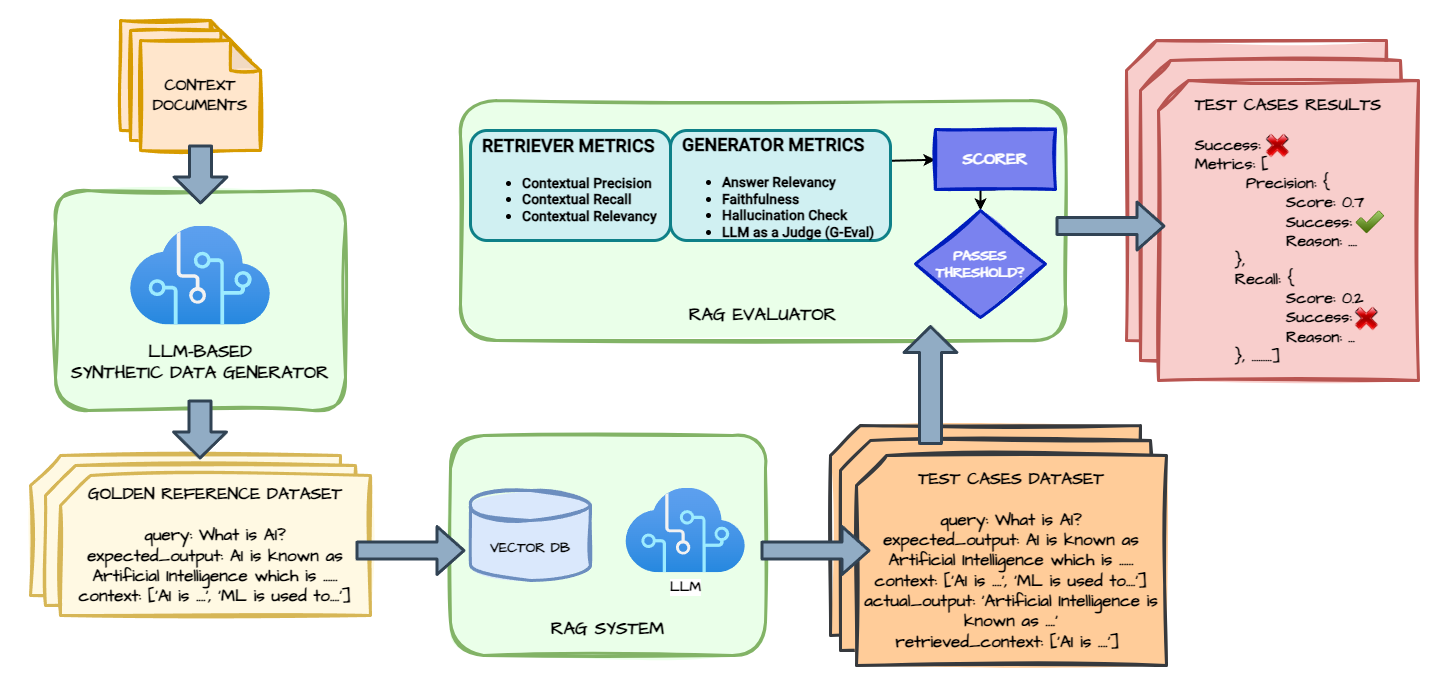

#Create a Synthetic RAG Golden Reference Dataset

In [ ]:
doc_contexts = [doc.page_content for doc in paper_docs]
doc_contexts_reduced = doc_contexts[:10]

In [ ]:
from deepeval.synthesizer import Synthesizer
from deepeval.synthesizer import types

/usr/local/lib/python3.11/dist-packages/deepeval/__init__.py:49: UserWarning: You are using deepeval version 1.4.7, however version 2.3.6 is available. You should consider upgrading via the "pip install --upgrade deepeval" command.
  warnings.warn(


In [ ]:
synthesizer = Synthesizer(model='gpt-4o',
                          embedder=OpenAIEmbeddings())

eval_data = synthesizer.generate_goldens(
    # Provide a list of context for synthetic data generation
    contexts=[[doc] for doc in doc_contexts_reduced],
    include_expected_output=True,
    max_goldens_per_context=1,
    num_evolutions=1,
    scenario="Retrieval Augmented Generation",
    task="Question Answering",
    evolutions={
        types.Evolution.REASONING: 0.1,     # Evolves the input to require multi-step logical thinking.
        types.Evolution.MULTICONTEXT: 0.9,  # Ensures that all relevant information from the context is utilized.
        types.Evolution.CONCRETIZING: 0.0,  # Makes abstract ideas more concrete and detailed.
        types.Evolution.CONSTRAINED: 0.0,   # Introduces a condition or restriction, testing the model's ability to operate within specific limits.
        types.Evolution.COMPARATIVE: 0.0,   # Requires a response that involves a comparison between options or contexts.
        types.Evolution.HYPOTHETICAL: 0.0,  # Forces the model to consider and respond to a hypothetical scenario.
        types.Evolution.IN_BREADTH: 0.0,    # Broadens the input to touch on related or adjacent topics.
    }
)

Event loop is already running. Applying nest_asyncio patch to allow async execution...


✨ Generating up to 10 goldens using DeepEval (using gpt-4o, use case=QA, method=default):  60%|██████    | 6/10 [00:16<00:05,  1.37s/it]ERROR:root:OpenAI rate limit exceeded. Retrying: 1 time(s)...
✨ Generating up to 10 goldens using DeepEval (using gpt-4o, use case=QA, method=default): 100%|██████████| 10/10 [00:31<00:00,  3.16s/it]


✓ Generation finished 🎉! You can also run 'deepeval login' to generate and save goldens directly on Confident AI.

In [ ]:
eval_data[0]

Golden(input='How does Augusta improve initial GRN estimates using transcription factors through a multi-step process?', actual_output=None, expected_output='Augusta improves initial GRN estimates by refining them using transcription factor binding motif predictions and incorporating verified interactions from databases. This multi-step process involves predicting transcription factor binding motifs in the promoters of regulated genes and utilizing verified interactions to enhance the accuracy of the initial gene regulatory network inference. This approach is particularly beneficial for non-model organisms where database information is limited.', context=["Describes the development and functionality of Augusta, an open-source Python package designed for inferring Gene Regulatory Networks (GRNs) and Boolean Networks (BNs) from high-throughput gene expression data. Highlights Augusta's unique approach of refining initial GRN estimations through transcription factor binding motif predicti

#Save the Synthetic RAG Golden Reference Dataset

In [ ]:
import dill

In [ ]:
with open('golden_ref_data.bin', 'wb') as f:
    dill.dump(eval_data, f)

##Create RAG Evaluation Dataset

In [ ]:
from deepeval.dataset import EvaluationDataset

eval_dataset = EvaluationDataset()

# load golden dataset
with open('golden_ref_data.bin', 'rb') as f:
    golden_docs = dill.load(f)

eval_dataset.goldens = golden_docs

In [ ]:
eval_dataset.goldens[0]

Golden(input='How does Augusta improve initial GRN estimates using transcription factors through a multi-step process?', actual_output=None, expected_output='Augusta improves initial GRN estimates by refining them using transcription factor binding motif predictions and incorporating verified interactions from databases. This multi-step process involves predicting transcription factor binding motifs in the promoters of regulated genes and utilizing verified interactions to enhance the accuracy of the initial gene regulatory network inference. This approach is particularly beneficial for non-model organisms where database information is limited.', context=["Describes the development and functionality of Augusta, an open-source Python package designed for inferring Gene Regulatory Networks (GRNs) and Boolean Networks (BNs) from high-throughput gene expression data. Highlights Augusta's unique approach of refining initial GRN estimations through transcription factor binding motif predicti

In [ ]:
eval_dataset.goldens[0].input

'How does Augusta improve initial GRN estimates using transcription factors through a multi-step process?'

In [ ]:
rag_chain_w_sources.invoke(eval_dataset.goldens[0].input)

{'context': [Document(metadata={'id': 'fd1d7c64-84d0-463f-9eb1-0a2f6f14d07d', 'page': 5, 'source': './infection_studies/Augusta_From_RNA.pdf', 'title': 'Augusta_From_RNA.pdf'}, page_content='Focuses on the results of the Gene Regulatory Network (GRN) refinement process using the Augusta tool, highlighting the improved performance in predicting transcription factors (TFs) and target genes (TGs) compared to the initial GRN. It discusses the significance of network refinement through Gene Ontology (GO) enrichment analysis, despite the overestimation of predicted TFs, and emphasizes the challenges of working with sparse time-series transcription data from non-model organisms.\ntranscription factors (TFs) and 1880 target genes (TGs). This refined \nnetwork outperformed the initial GRN obtained solely by the calculation \nof mutual information (MI), which consisted of 4684 TFs and 4529 TGs. \nThe significant improvement achieved through network refinement \nhighlights its importance. To furt

In [ ]:
from typing import List
from deepeval.test_case import LLMTestCase
from deepeval.dataset import Golden
from tqdm import tqdm

def convert_goldens_to_test_cases(goldens: List[Golden]) -> List[LLMTestCase]:
    test_cases = []
    for golden in tqdm(goldens):
        response_obj = rag_chain_w_sources.invoke(golden.input)
        test_case = LLMTestCase(
            input=golden.input,
            actual_output=response_obj['response'],
            expected_output=golden.expected_output,
            context=golden.context,
            retrieval_context=[doc.page_content for doc in response_obj['context']]
        )
        test_cases.append(test_case)
    return test_cases

In [ ]:
eval_dataset.test_cases = convert_goldens_to_test_cases(eval_dataset.goldens)

100%|██████████| 10/10 [01:24<00:00,  8.42s/it]


In [ ]:
eval_dataset.test_cases[0]

LLMTestCase(input='How does Augusta improve initial GRN estimates using transcription factors through a multi-step process?', actual_output='Augusta improves initial Gene Regulatory Network (GRN) estimates through a multi-step process that involves the following key components:\n\n1. **Initial GRN Inference**: The process begins with the inference of an initial GRN from time-course gene expression datasets. This involves calculating mutual information (MI) from the gene expression data, which is a quick step that takes seconds to minutes.\n\n2. **Transcription Factor Binding Motif (TFBM) Searches**: The refinement of the initial GRN is the most time-consuming part of the process. This step includes searching for transcription factor binding motifs in the promoter regions of the regulated genes. The promoter sequences are extracted from the genome and analyzed using the MEME Suite web server, which can involve queuing times for custom analysis.\n\n3. **Incorporation of Verified Interact

#Run and View RAG Evaluations on the Evaluation Dataset

In [ ]:
from deepeval import evaluate
from deepeval.metrics import ContextualPrecisionMetric, ContextualRecallMetric, ContextualRelevancyMetric
from deepeval.metrics import AnswerRelevancyMetric, FaithfulnessMetric, HallucinationMetric
from deepeval.metrics.ragas import RAGASAnswerRelevancyMetric

contextual_precision = ContextualPrecisionMetric(threshold=0.5, include_reason=True, model="gpt-4o")
contextual_recall = ContextualRecallMetric(threshold=0.5, include_reason=True, model="gpt-4o")
contextual_relevancy = ContextualRelevancyMetric(threshold=0.5, include_reason=True, model="gpt-4o")
answer_relevancy = AnswerRelevancyMetric(threshold=0.5, include_reason=True, model="gpt-4o")
faithfulness = FaithfulnessMetric(threshold=0.5, include_reason=True, model="gpt-4o")
hallucination = HallucinationMetric(threshold=0.5, include_reason=True, model="gpt-4o")
ragas_answer_relevancy = RAGASAnswerRelevancyMetric(threshold=0.5, embeddings=OpenAIEmbeddings(), model="gpt-4o")

eval_results = evaluate(test_cases=eval_dataset.test_cases[:3],
                        metrics=[contextual_precision, contextual_recall, contextual_relevancy,
                                 answer_relevancy, ragas_answer_relevancy, faithfulness, hallucination])

✨ You're running DeepEval's latest Contextual Precision Metric! (using gpt-4o, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Contextual Recall Metric! (using gpt-4o, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Contextual Relevancy Metric! (using gpt-4o, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Answer Relevancy Metric! (using gpt-4o, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Answer Relevancy (ragas) Metric! (using gpt-4o, strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Faithfulness Metric! (using gpt-4o, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Hallucination Metric! (using gpt-4o, strict=False, async_mode=True)...

Event loop is already running. Applying nest_asyncio patch to allow async execution...


Evaluating 3 test case(s) in parallel: |          |  0% (0/3) [Time Taken: 00:00, ?test case/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

None


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

None


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

None


ERROR:root:OpenAI rate limit exceeded. Retrying: 1 time(s)...
ERROR:root:OpenAI rate limit exceeded. Retrying: 1 time(s)...
ERROR:root:OpenAI rate limit exceeded. Retrying: 1 time(s)...
ERROR:root:OpenAI rate limit exceeded. Retrying: 13 time(s)...
ERROR:root:OpenAI rate limit exceeded. Retrying: 13 time(s)...
ERROR:root:OpenAI rate limit exceeded. Retrying: 1 time(s)...
ERROR:root:OpenAI rate limit exceeded. Retrying: 13 time(s)...
ERROR:root:OpenAI rate limit exceeded. Retrying: 13 time(s)...
ERROR:root:OpenAI rate limit exceeded. Retrying: 13 time(s)...
ERROR:root:OpenAI rate limit exceeded. Retrying: 13 time(s)...
ERROR:root:OpenAI rate limit exceeded. Retrying: 13 time(s)...
ERROR:root:OpenAI rate limit exceeded. Retrying: 13 time(s)...
ERROR:root:OpenAI rate limit exceeded. Retrying: 13 time(s)...
ERROR:root:OpenAI rate limit exceeded. Retrying: 12 time(s)...
ERROR:root:OpenAI rate limit exceeded. Retrying: 13 time(s)...
ERROR:root:OpenAI rate limit exceeded. Retrying: 1 time(s).

ValueError: Evaluation LLM outputted an invalid JSON. Please use a better evaluation model.

In [ ]:
eval_metrics = []
for result in eval_results.test_results:
    eval_dict = {}
    eval_dict['Input'] = result.input
    eval_dict['Expected Output'] = result.expected_output
    eval_dict['Actual Output'] = result.actual_output
    eval_dict['Context'] = result.context
    eval_dict['Retrieval Context'] = result.retrieval_context
    eval_dict['Success'] = result.success
    metrics = result.metrics_data
    for metric in metrics:
        eval_dict[metric.name+'_Score'] = metric.score
    for metric in metrics:
        eval_dict[metric.name+'_Success'] = metric.success
    for metric in metrics:
        eval_dict[metric.name+'_Reason'] = metric.reason
    eval_metrics.append(eval_dict)

In [ ]:
import pandas as pd

eval_results_df = pd.DataFrame(eval_metrics)
eval_results_df.T

In [ ]:
eval_results_df[['Contextual Precision_Score', 'Contextual Recall_Score', 'Contextual Relevancy_Score',
                 'Answer Relevancy_Score', 'Answer Relevancy (ragas)_Score',
                 'Faithfulness_Score', 'Hallucination_Score']].describe()